In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#from fbprophet import Prophet

In [5]:
df_recent = pd.read_csv('../data/energy_recent_clean.csv', index_col = 'date')
df_past = pd.read_csv('../data/energy_past_clean.csv', index_col = 'date')

df_recent.set_index(pd.to_datetime(df_recent.index), inplace = True)
df_past.set_index(pd.to_datetime(df_past.index), inplace = True)

## Nuclear Power: [Source](https://www.world-nuclear.org/information-library/country-profiles/countries-t-z/usa-nuclear-power.aspx)

Nuclear has stayed pretty stable over the past few decades, but with renewed interest and new construction, that could change.


- There are currently 98 operating reactors in the United States over 60 different facilities. 
- "Almost all the US nuclear generating capacity comes from reactors built between 1967 and 1990. Until 2013 there had been no new construction starts since 1977, largely because for a number of years gas generation was considered more economically attractive and because construction schedules during the 1970s and 1980s had frequently been extended by opposition, compounded by heightened safety fears following the Three Mile Island accident in 1979"
- Many reactors are old and suffering damage, risking closure in the next few years, risking more uncertainty should no new regulations relieve the issue


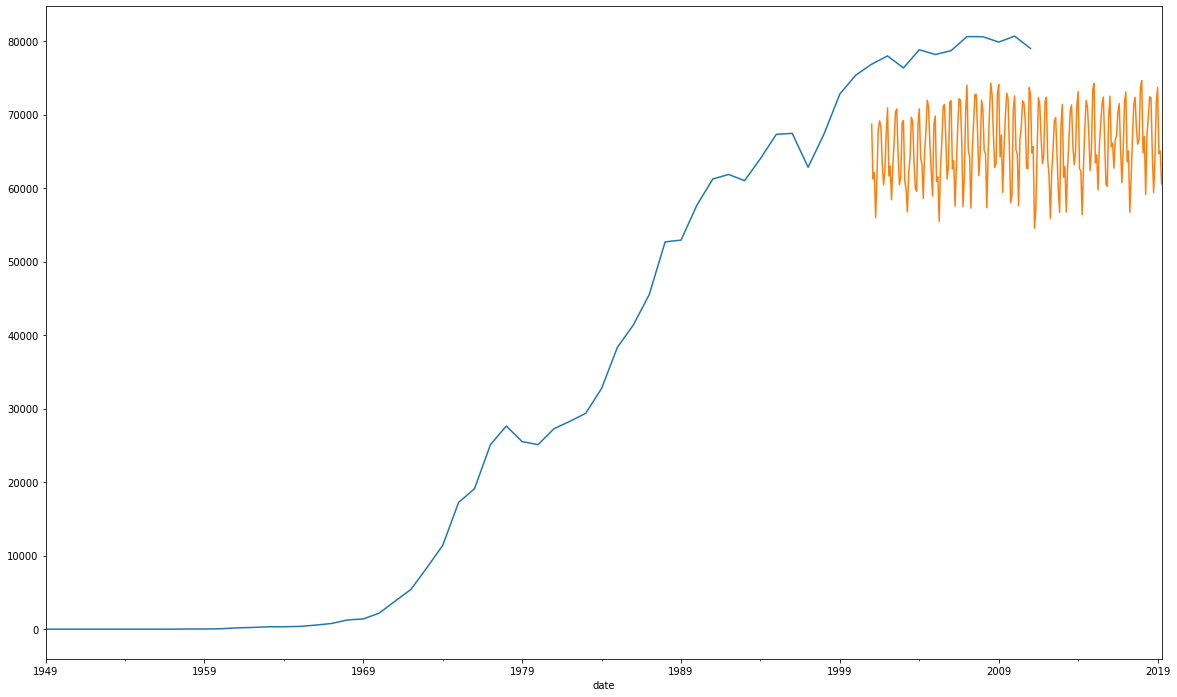

In [6]:
plt.figure(figsize = (20,12))
df_past['Nuclear'].plot()
df_recent['Nuclear'].plot()

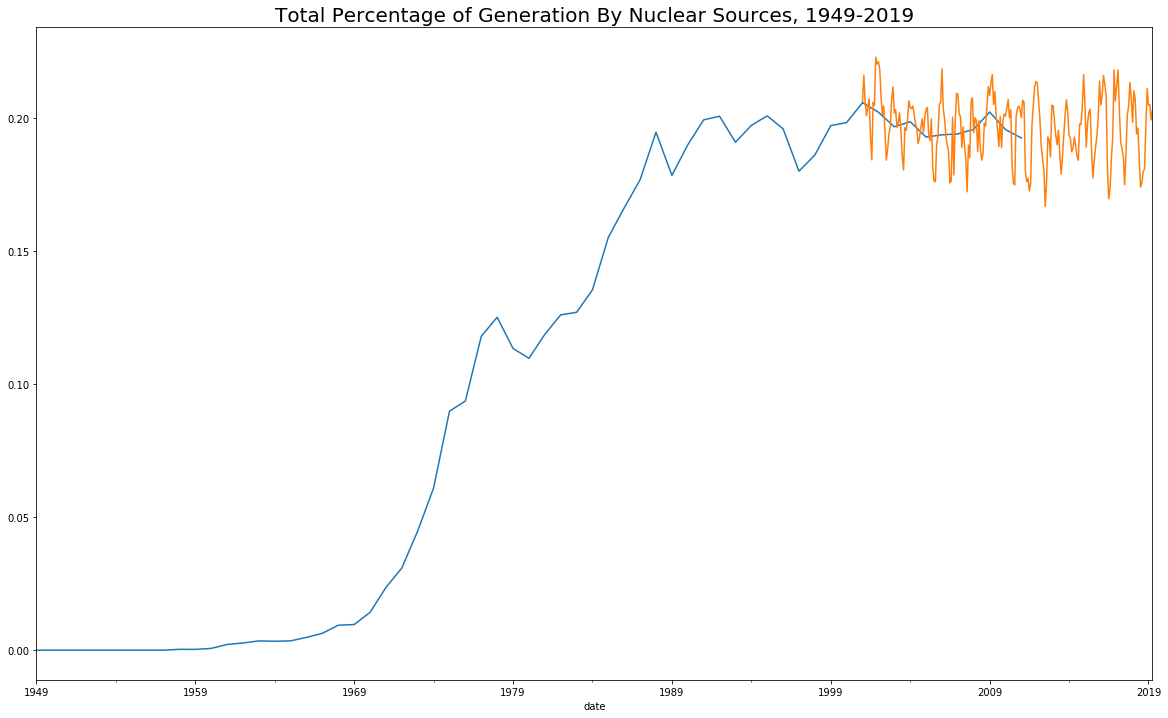

In [7]:
plt.figure(figsize = (20,12))
(df_past['Nuclear']/df_past['Total']).plot()
(df_recent['Nuclear']/df_recent['Total']).plot()
plt.title("Total Percentage of Generation By Nuclear Sources, 1949-2019", size = 20);

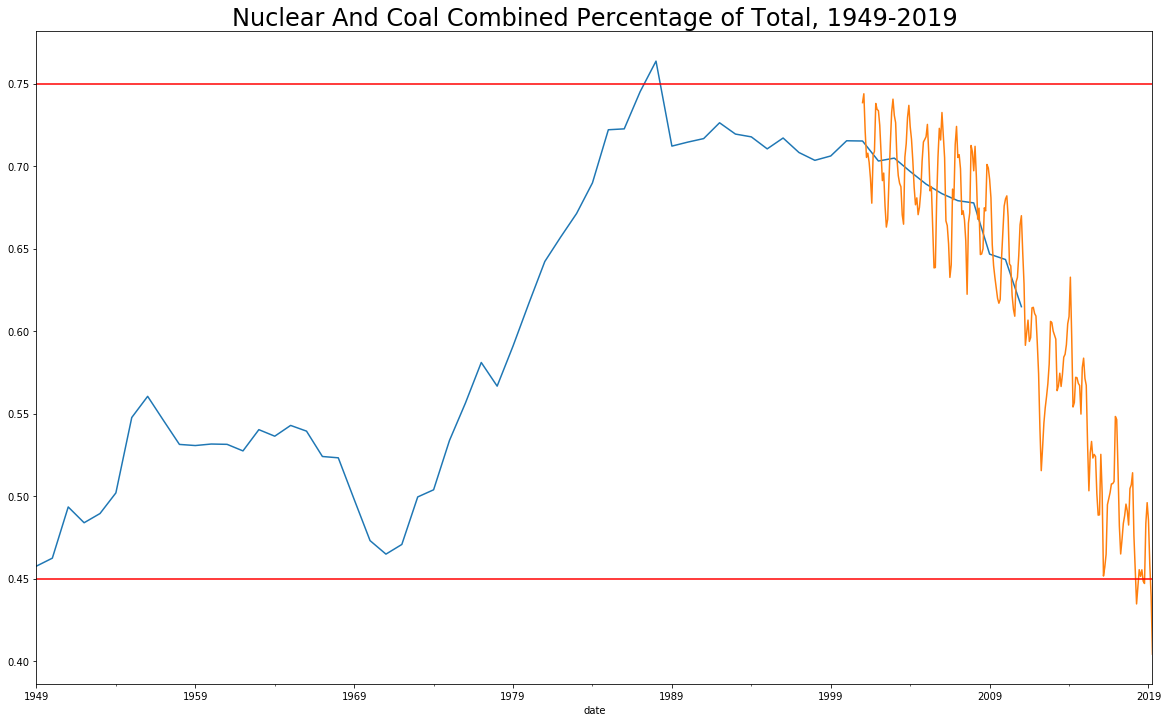

In [8]:
plt.figure(figsize = (20,12))
((df_past['Nuclear'] + df_past['Coal'])/df_past['Total']).plot()
((df_recent['Nuclear']+ df_recent['Coal'])/df_recent['Total']).plot()
plt.title("Nuclear And Coal Combined Percentage of Total, 1949-2019", size = 24)
plt.axhline(0.45, color = 'red')
plt.axhline(0.75, color = 'red')

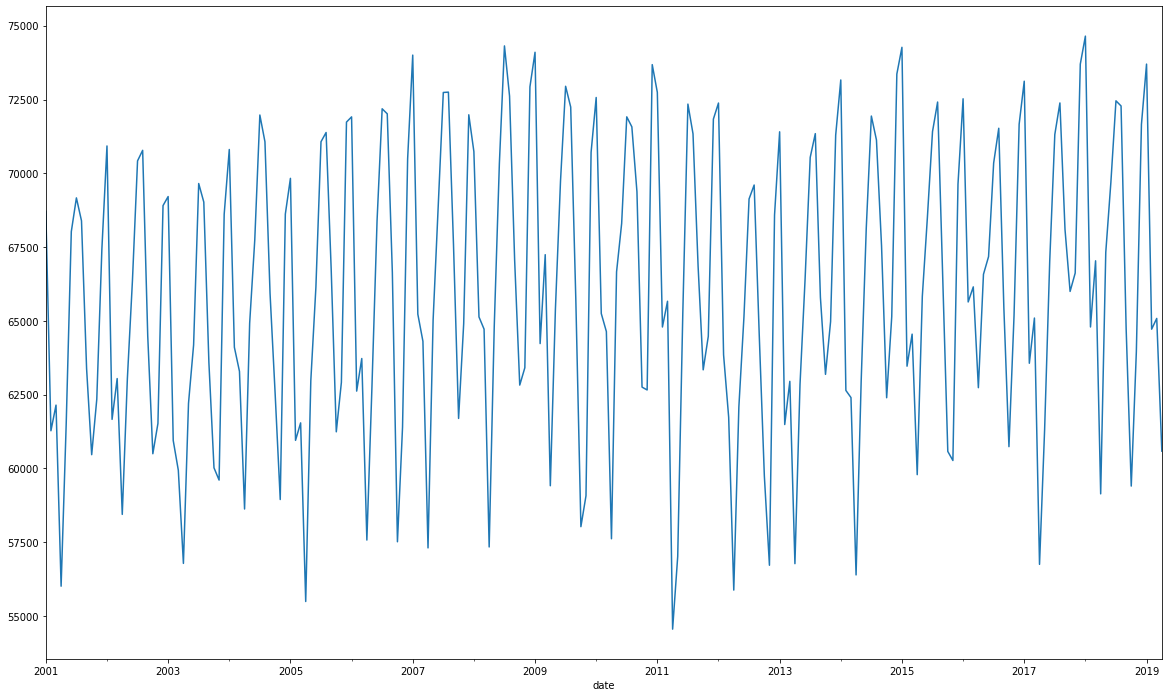

In [9]:
df_recent['Nuclear'].plot(figsize = (20,12))

In [10]:
nuclear = pd.DataFrame(data = df_recent.index)
nuclear['y'] = list(df_recent['Nuclear'])
nuclear.rename(columns = {'date': 'ds'}, inplace = True)
nuclear.head()

,ds,y
0,2001-01-01,68707.0
1,2001-02-01,61272.0
2,2001-03-01,62141.0
3,2001-04-01,56003.0
4,2001-05-01,61512.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
train, test = train_test_split(nuclear, shuffle = False)
model_train = Prophet(growth = 'linear', seasonality_mode= 'multiplicative')
model_train.fit(train)
train_future = model_train.make_future_dataframe(periods = test.shape[0], freq = 'M')
train_pred = model_train.predict(train_future)
np.sqrt(mean_squared_error(test['y'], train_pred['yhat'][-55:]))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3220.931184127836

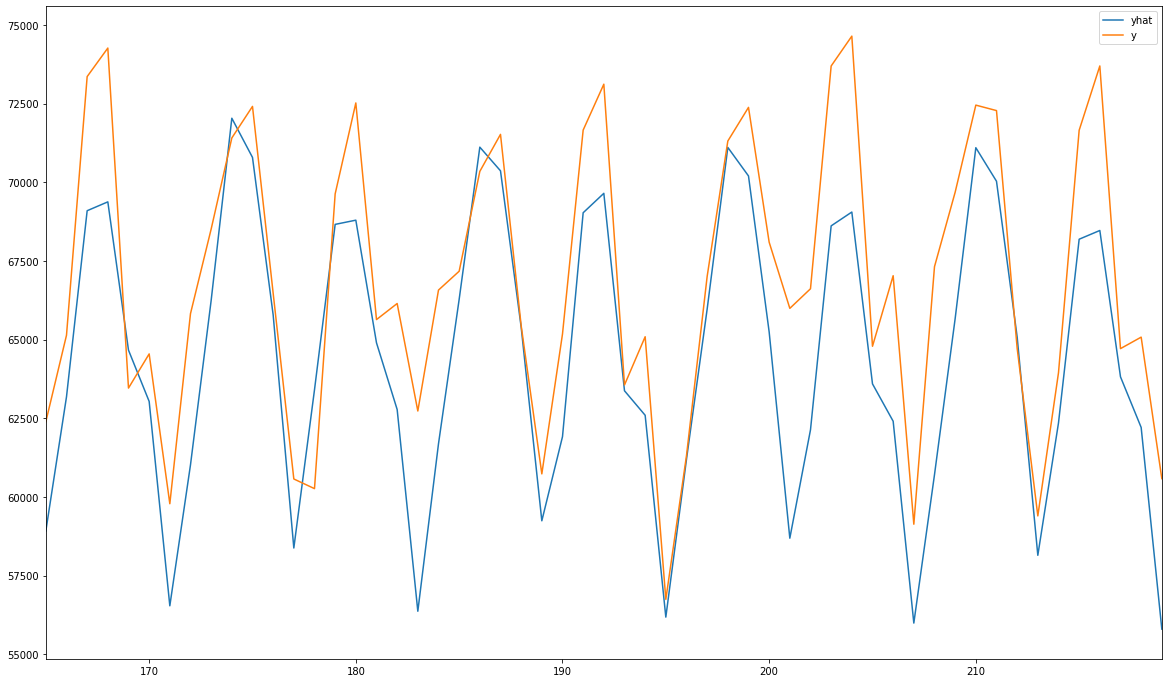

In [12]:
plt.figure(figsize = (20,12))
train_pred['yhat'][-55:].plot()
test['y'].plot()
plt.legend()

In [10]:
model_nuclear = Prophet(growth = 'linear', seasonality_mode= 'additive', n_changepoints= 2)
model_nuclear.fit(nuclear)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
nuclear_future = model_nuclear.make_future_dataframe(periods = 372, freq = 'M')
nuclear_future['cap'] = 80_000
nuclear_future.tail()

,ds,cap
587,2049-11-30,80000
588,2049-12-31,80000
589,2050-01-31,80000
590,2050-02-28,80000
591,2050-03-31,80000


In [12]:
nuclear_pred = model_nuclear.predict(nuclear_future)

In [13]:
nuclear_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
577,2049-01-31,77341.938479,56968.402870,97688.038345
578,2049-02-28,76136.837733,56227.362227,95773.165088
579,2049-03-31,69832.690777,49364.378732,89812.207024
580,2049-04-30,75404.686097,55441.687860,96054.009152
581,2049-05-31,80122.092503,60076.780606,100430.729443
582,2049-06-30,84857.810925,64606.913149,105399.794583
583,2049-07-31,84395.300889,63453.449823,104716.100263
584,2049-08-31,79142.540768,58715.432995,99864.005935
585,2049-09-30,72846.101638,51545.341320,94147.932318
586,2049-10-31,75634.886879,55095.445696,96848.638010


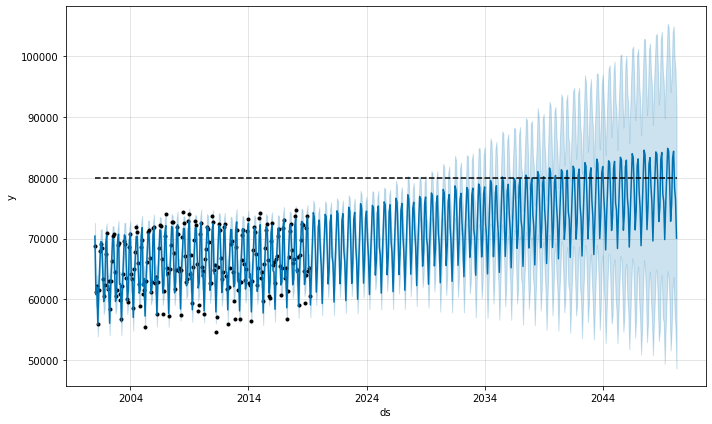

In [14]:
fig1 = model_nuclear.plot(nuclear_pred)

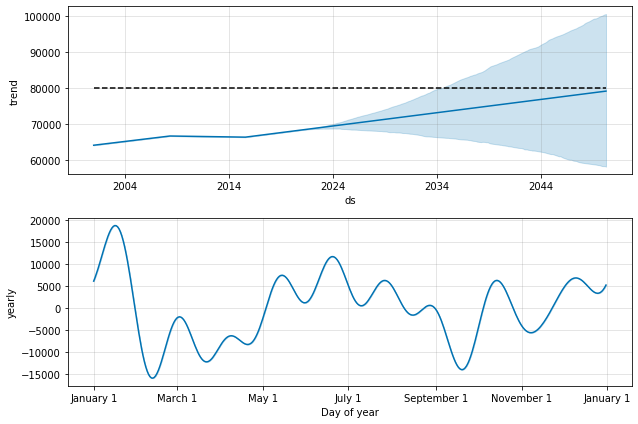

In [15]:
fig2 = model_nuclear.plot_components(nuclear_pred)

In [16]:
nuclear_pred.to_csv("../data/Predictions_Nuclear")